_Lambda School Data Science, Unit 2_

# Classification 2 Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [315]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [316]:
target = 'Fail'

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

In [429]:
import re
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split as tts

In [430]:
train.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0


In [431]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [432]:
train.describe(include='number')

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [433]:
train.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,51916,51293,51692,51904,51916,51863,51906,51916,51915,42261,51718
unique,17049,16350,329,3,13954,39,1,2257,51,42164,13410
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2017-03-23T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,654,802,34264,37731,741,51659,51906,50,24170,3,741


In [452]:
train['Inspection Type'].value_counts()

Canvass                                   24170
License                                    7825
Canvass Re-Inspection                      6346
Complaint                                  4948
License Re-Inspection                      3002
Complaint Re-Inspection                    2241
Short Form Complaint                       2103
License-Task Force                          214
Suspected Food Poisoning                    207
Consultation                                189
Tag Removal                                 146
Out of Business                             109
Task Force Liquor 1475                       92
Recent Inspection                            66
Suspected Food Poisoning Re-inspection       58
Complaint-Fire                               51
Short Form Fire-Complaint                    36
No Entry                                     21
Special Events (Festivals)                   21
Package Liquor 1474                          16
Complaint-Fire Re-inspection            

#### Leakage

The Violations feature is leakage. Leakage is described as a feature which we only have data on after what we are testing for has already occured. Since we are trying to predict whether a location failed a safety inspection and we can only know violations after a safety inspection already occured, we should not use it to train our model.

In [530]:
def x_y_split(df, target):
    x = df.drop(columns=target)
    y = df[target]
    return x,y

def wrangle(df):
    drop_me = ['DBA Name','AKA Name', 'Violations', 'Location', 'Address', 
               'Inspection Date', 'State', 
               'Inspection ID', 'City']
    is_missing = ['Risk', 'License #', 'Facility Type']
    df = df.copy()
    
    df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
    df['Year'] = df['Inspection Date'].dt.year
    df['Month'] = df['Inspection Date'].dt.month
    
    def regex_f(search_me):
        if type(search_me) == str:
            match = re.match(r'\D*(\d)\D*', search_me)
            if match:
                return int(match.group(1))
    df['Risk'] = df['Risk'].apply(regex_f)
    
    df['License #'] = df['License #'].replace(0, np.NaN)
    
    if True:
        for col in is_missing:
            df[f'{col}_ISMISSING'] = df[col].isna().astype(int)
    
    return df.drop(columns=drop_me)

def pre_process(df):
    x_w = wrangle(df)
    
    pre_p = make_pipeline(
        ce.OrdinalEncoder(), 
        SimpleImputer(strategy='mean')
    )
    df_e = pre_p.fit_transform(x_w)
    df_e = pd.DataFrame(df_e)
    df_e.columns = x_w.columns
    return df_e

In [531]:
x, y = x_y_split(train, target)
x.shape, y.shape

((51916, 16), (51916,))

In [532]:
diff = set(x.columns) ^ set(wrangle(x).columns)
dropped = set(x.columns) & diff
added = set(wrangle(x).columns) & diff
common = set(x.columns) & set(wrangle(x).columns)

In [533]:
dropped

{'AKA Name',
 'Address',
 'City',
 'DBA Name',
 'Inspection Date',
 'Inspection ID',
 'Location',
 'State',
 'Violations'}

In [534]:
added

{'Facility Type_ISMISSING',
 'License #_ISMISSING',
 'Month',
 'Risk_ISMISSING',
 'Year'}

In [535]:
common

{'Facility Type',
 'Inspection Type',
 'Latitude',
 'License #',
 'Longitude',
 'Risk',
 'Zip'}

#### START: Wrangle Testing and Decision making

In [536]:
x_w = wrangle(x)
x_w.describe(include='number')

,License #,Risk,Zip,Latitude,Longitude,Year,Month,Risk_ISMISSING,License #_ISMISSING,Facility Type_ISMISSING
count,5.176800e+04,51904.000000,51890.000000,51718.000000,51718.000000,51916.000000,51916.000000,51916.000000,51916.000000,51916.000000
mean,1.553771e+06,1.350840,60628.834669,41.879568,-87.676663,2013.914593,6.362875,0.000231,0.002851,0.004315
std,8.993833e+05,0.619124,22.736963,0.081126,0.059509,2.531524,3.365434,0.015202,0.053317,0.065545
min,2.000000e+00,1.000000,60007.000000,41.644670,-87.914428,2010.000000,1.000000,0.000000,0.000000,0.000000
25%,1.142451e+06,1.000000,60614.000000,41.830296,-87.707857,2012.000000,3.000000,0.000000,0.000000,0.000000
50%,1.959502e+06,1.000000,60625.000000,41.890166,-87.666524,2014.000000,6.000000,0.000000,0.000000,0.000000
75%,2.215535e+06,2.000000,60643.000000,41.939167,-87.634461,2016.000000,9.000000,0.000000,0.000000,0.000000
max,8.700606e+06,3.000000,60827.000000,42.021064,-87.525094,2019.000000,12.000000,1.000000,1.000000,1.000000


In [537]:
x_w.describe(exclude='number')

,Facility Type,Inspection Type
count,51692,51915
unique,329,51
top,Restaurant,Canvass
freq,34264,24170


In [538]:
x_w.isna().sum()

License #                  148
Facility Type              224
Risk                        12
Zip                         26
Inspection Type              1
Latitude                   198
Longitude                  198
Year                         0
Month                        0
Risk_ISMISSING               0
License #_ISMISSING          0
Facility Type_ISMISSING      0
dtype: int64

#### END: Wrangle Testing

In [539]:
x_TEST, y_TEST = x_y_split(test, target)
x_TEST.shape, y_TEST.shape, test.shape

((17306, 16), (17306,), (17306, 17))

In [540]:
x, y = x_y_split(train, target)
x.shape, y.shape, train.shape

((51916, 16), (51916,), (51916, 17))

In [541]:
x_train, x_val, y_train, y_val = tts(x, y, test_size=.25, random_state=42)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((38937, 16), (12979, 16), (38937,), (12979,))

In [542]:
x_train_p = pre_process(x_train)
x_val_p = pre_process(x_val)
x_test_p = pre_process(x_TEST)

x_train_p.shape, x_val_p.shape, x_test_p.shape

((38937, 12), (12979, 12), (17306, 12))

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._



In [543]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [544]:
param_distributions = {
    'xgbclassifier__n_estimators': randint(500, 1000),
    'xgbclassifier__max_depth': randint(3, 7)
}
model = XGBClassifier()
search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=15,
    cv=2,
    scoring='roc_auc',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(x_train_p, y_train)

model_one = XGBClassifier(n_estimators=search.best_params_['xgbclassifier__max_depth'],
                          max_depth=search.best_params_['xgbclassifier__max_depth'],
                          n_jobs = -1
                         )
model_one.fit(x_train_p,
              y_train,
             )

y_val_pred = model_one.predict(x_val_p)
print(f' AUC ACCURACY SCORE: {roc_auc_score(y_val, y_val_pred)}')

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   33.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.8s finished


 AUC ACCURACY SCORE: 0.5008624114374904


In [545]:
eval_set = [(x_train_p, y_train),
            (x_val_p, y_val)
           ]
model_two = XGBClassifier(n_estimators = 2000)
model_two.fit(x_train_p, 
              y_train, 
              eval_set=eval_set, 
              eval_metric='auc', 
              early_stopping_rounds=50
             )
y_val_pred = model_two.predict(x_val_p)
roc_auc_score(y_val, y_val_pred)

[0]	validation_0-auc:0.664556	validation_1-auc:0.490408
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.66493	validation_1-auc:0.490051
[2]	validation_0-auc:0.664863	validation_1-auc:0.488815
[3]	validation_0-auc:0.665661	validation_1-auc:0.477342
[4]	validation_0-auc:0.666621	validation_1-auc:0.469916
[5]	validation_0-auc:0.666352	validation_1-auc:0.470702
[6]	validation_0-auc:0.666419	validation_1-auc:0.471698
[7]	validation_0-auc:0.666878	validation_1-auc:0.470636
[8]	validation_0-auc:0.66684	validation_1-auc:0.471727
[9]	validation_0-auc:0.673772	validation_1-auc:0.478735
[10]	validation_0-auc:0.680613	validation_1-auc:0.468005
[11]	validation_0-auc:0.680951	validation_1-auc:0.467265
[12]	validation_0-auc:0.681323	validation_1-auc:0.468685
[13]	validation_0-auc:0.688515	validation_1-auc:0.469706
[14]	validation_0-auc:0.689231	validation_1-auc:0.470217


[141]	validation_0-auc:0.730868	validation_1-auc:0.540765
[142]	validation_0-auc:0.731048	validation_1-auc:0.542329
[143]	validation_0-auc:0.731215	validation_1-auc:0.542829
[144]	validation_0-auc:0.731284	validation_1-auc:0.542768
[145]	validation_0-auc:0.731324	validation_1-auc:0.542788
[146]	validation_0-auc:0.73137	validation_1-auc:0.54281
[147]	validation_0-auc:0.731414	validation_1-auc:0.542822
[148]	validation_0-auc:0.731517	validation_1-auc:0.542914
[149]	validation_0-auc:0.731566	validation_1-auc:0.542859
[150]	validation_0-auc:0.731758	validation_1-auc:0.542821
[151]	validation_0-auc:0.732116	validation_1-auc:0.543335
[152]	validation_0-auc:0.732337	validation_1-auc:0.543778
[153]	validation_0-auc:0.732444	validation_1-auc:0.543988
[154]	validation_0-auc:0.732558	validation_1-auc:0.543886
[155]	validation_0-auc:0.73275	validation_1-auc:0.543893
[156]	validation_0-auc:0.732796	validation_1-auc:0.543904
[157]	validation_0-auc:0.732957	validation_1-auc:0.544055
[158]	validation_

[283]	validation_0-auc:0.748664	validation_1-auc:0.551405
[284]	validation_0-auc:0.748692	validation_1-auc:0.551405
[285]	validation_0-auc:0.748736	validation_1-auc:0.551409
[286]	validation_0-auc:0.748882	validation_1-auc:0.551372
[287]	validation_0-auc:0.749045	validation_1-auc:0.551502
[288]	validation_0-auc:0.749135	validation_1-auc:0.551566
[289]	validation_0-auc:0.749156	validation_1-auc:0.551553
[290]	validation_0-auc:0.749273	validation_1-auc:0.551544
[291]	validation_0-auc:0.749333	validation_1-auc:0.551565
[292]	validation_0-auc:0.749381	validation_1-auc:0.551669
[293]	validation_0-auc:0.749494	validation_1-auc:0.551889
[294]	validation_0-auc:0.749566	validation_1-auc:0.551903
[295]	validation_0-auc:0.74959	validation_1-auc:0.551876
[296]	validation_0-auc:0.749697	validation_1-auc:0.551953
[297]	validation_0-auc:0.749762	validation_1-auc:0.552021
[298]	validation_0-auc:0.749924	validation_1-auc:0.551935
[299]	validation_0-auc:0.749973	validation_1-auc:0.551916
[300]	validatio

[425]	validation_0-auc:0.761796	validation_1-auc:0.558031
[426]	validation_0-auc:0.761836	validation_1-auc:0.55806
[427]	validation_0-auc:0.76191	validation_1-auc:0.558227
[428]	validation_0-auc:0.761993	validation_1-auc:0.558332
[429]	validation_0-auc:0.76207	validation_1-auc:0.558323
[430]	validation_0-auc:0.762149	validation_1-auc:0.558386
[431]	validation_0-auc:0.762203	validation_1-auc:0.558372
[432]	validation_0-auc:0.762255	validation_1-auc:0.558368
[433]	validation_0-auc:0.762373	validation_1-auc:0.558385
[434]	validation_0-auc:0.762502	validation_1-auc:0.558495
[435]	validation_0-auc:0.762562	validation_1-auc:0.55858
[436]	validation_0-auc:0.762613	validation_1-auc:0.558605
[437]	validation_0-auc:0.762704	validation_1-auc:0.558583
[438]	validation_0-auc:0.762827	validation_1-auc:0.558599
[439]	validation_0-auc:0.762849	validation_1-auc:0.558599
[440]	validation_0-auc:0.762852	validation_1-auc:0.558615
[441]	validation_0-auc:0.762991	validation_1-auc:0.558659
[442]	validation_0

[567]	validation_0-auc:0.772018	validation_1-auc:0.560506
[568]	validation_0-auc:0.772052	validation_1-auc:0.560506
[569]	validation_0-auc:0.7721	validation_1-auc:0.560472
[570]	validation_0-auc:0.772166	validation_1-auc:0.560523
[571]	validation_0-auc:0.772324	validation_1-auc:0.560555
[572]	validation_0-auc:0.772411	validation_1-auc:0.560594
[573]	validation_0-auc:0.772496	validation_1-auc:0.560591
[574]	validation_0-auc:0.772568	validation_1-auc:0.560585
[575]	validation_0-auc:0.772574	validation_1-auc:0.560676
[576]	validation_0-auc:0.772645	validation_1-auc:0.560671
[577]	validation_0-auc:0.772757	validation_1-auc:0.560786
[578]	validation_0-auc:0.772769	validation_1-auc:0.561014
[579]	validation_0-auc:0.772825	validation_1-auc:0.561015
[580]	validation_0-auc:0.772851	validation_1-auc:0.561022
[581]	validation_0-auc:0.772905	validation_1-auc:0.560973
[582]	validation_0-auc:0.772956	validation_1-auc:0.561035
[583]	validation_0-auc:0.772999	validation_1-auc:0.561058
[584]	validation

[709]	validation_0-auc:0.781319	validation_1-auc:0.564029
[710]	validation_0-auc:0.781392	validation_1-auc:0.563967
[711]	validation_0-auc:0.781466	validation_1-auc:0.564054
[712]	validation_0-auc:0.781516	validation_1-auc:0.564046
[713]	validation_0-auc:0.781599	validation_1-auc:0.564054
[714]	validation_0-auc:0.781637	validation_1-auc:0.564087
[715]	validation_0-auc:0.781685	validation_1-auc:0.564159
[716]	validation_0-auc:0.781683	validation_1-auc:0.564382
[717]	validation_0-auc:0.781774	validation_1-auc:0.564309
[718]	validation_0-auc:0.781783	validation_1-auc:0.564307
[719]	validation_0-auc:0.781797	validation_1-auc:0.564314
[720]	validation_0-auc:0.781844	validation_1-auc:0.564325
[721]	validation_0-auc:0.781855	validation_1-auc:0.564091
[722]	validation_0-auc:0.781914	validation_1-auc:0.564048
[723]	validation_0-auc:0.78196	validation_1-auc:0.564038
[724]	validation_0-auc:0.782004	validation_1-auc:0.564025
[725]	validation_0-auc:0.782029	validation_1-auc:0.564024
[726]	validatio

[851]	validation_0-auc:0.788778	validation_1-auc:0.567684
[852]	validation_0-auc:0.788832	validation_1-auc:0.567765
[853]	validation_0-auc:0.788882	validation_1-auc:0.567654
[854]	validation_0-auc:0.788956	validation_1-auc:0.567607
[855]	validation_0-auc:0.788993	validation_1-auc:0.567554
[856]	validation_0-auc:0.789078	validation_1-auc:0.567591
[857]	validation_0-auc:0.789184	validation_1-auc:0.567659
[858]	validation_0-auc:0.789211	validation_1-auc:0.567647
[859]	validation_0-auc:0.78925	validation_1-auc:0.567903
[860]	validation_0-auc:0.78933	validation_1-auc:0.567919
[861]	validation_0-auc:0.789455	validation_1-auc:0.568005
[862]	validation_0-auc:0.789585	validation_1-auc:0.568106
[863]	validation_0-auc:0.789708	validation_1-auc:0.568097
[864]	validation_0-auc:0.789731	validation_1-auc:0.568096
[865]	validation_0-auc:0.789738	validation_1-auc:0.568096
[866]	validation_0-auc:0.789798	validation_1-auc:0.568061
[867]	validation_0-auc:0.789879	validation_1-auc:0.568019
[868]	validation

[994]	validation_0-auc:0.795406	validation_1-auc:0.570179
[995]	validation_0-auc:0.795474	validation_1-auc:0.570096
[996]	validation_0-auc:0.795531	validation_1-auc:0.570056
[997]	validation_0-auc:0.795611	validation_1-auc:0.569966
[998]	validation_0-auc:0.795632	validation_1-auc:0.569972
[999]	validation_0-auc:0.795735	validation_1-auc:0.569993
[1000]	validation_0-auc:0.795736	validation_1-auc:0.569982
[1001]	validation_0-auc:0.795734	validation_1-auc:0.569992
[1002]	validation_0-auc:0.795807	validation_1-auc:0.570069
[1003]	validation_0-auc:0.795821	validation_1-auc:0.570071
[1004]	validation_0-auc:0.795837	validation_1-auc:0.570059
[1005]	validation_0-auc:0.795838	validation_1-auc:0.570049
[1006]	validation_0-auc:0.795904	validation_1-auc:0.570018
[1007]	validation_0-auc:0.795944	validation_1-auc:0.570046
[1008]	validation_0-auc:0.795996	validation_1-auc:0.570077
[1009]	validation_0-auc:0.796042	validation_1-auc:0.570089
[1010]	validation_0-auc:0.796088	validation_1-auc:0.570065
[10

[1134]	validation_0-auc:0.801937	validation_1-auc:0.571758
[1135]	validation_0-auc:0.801996	validation_1-auc:0.571801
[1136]	validation_0-auc:0.802028	validation_1-auc:0.571804
[1137]	validation_0-auc:0.802108	validation_1-auc:0.571838
[1138]	validation_0-auc:0.802207	validation_1-auc:0.571836
[1139]	validation_0-auc:0.802244	validation_1-auc:0.571819
[1140]	validation_0-auc:0.802301	validation_1-auc:0.571759
[1141]	validation_0-auc:0.802359	validation_1-auc:0.571787
[1142]	validation_0-auc:0.802377	validation_1-auc:0.571792
[1143]	validation_0-auc:0.802405	validation_1-auc:0.571792
[1144]	validation_0-auc:0.802473	validation_1-auc:0.571813
[1145]	validation_0-auc:0.802557	validation_1-auc:0.571837
[1146]	validation_0-auc:0.802605	validation_1-auc:0.572048
[1147]	validation_0-auc:0.802656	validation_1-auc:0.572049
[1148]	validation_0-auc:0.802713	validation_1-auc:0.572038
[1149]	validation_0-auc:0.802752	validation_1-auc:0.572011
[1150]	validation_0-auc:0.802781	validation_1-auc:0.5720

0.5284881762965687

In [553]:
y_test_pred = model_one.predict(x_test_p)
roc_auc_score(y_TEST, y_test_pred)

0.5023553466225521

In [554]:
y_test_pred = model_two.predict(x_test_p)
roc_auc_score(y_TEST, y_test_pred)

0.5063981131590783

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._


In [548]:
from xgboost import plot_importance
from pdpbox.pdp import pdp_isolate, pdp_plot

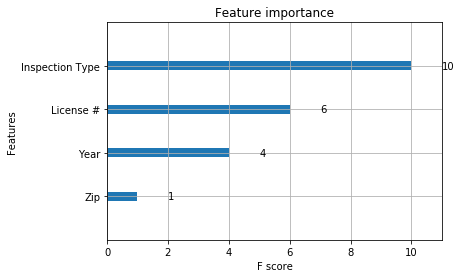

In [549]:
plot_importance(model_one)

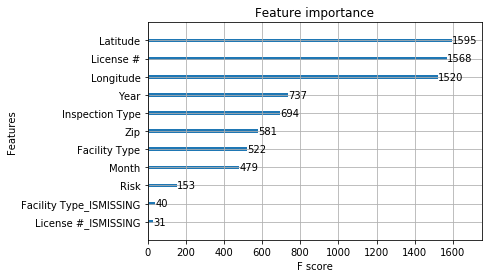

In [550]:
plot_importance(model_two)

###### Shows the predicted value if you varied the features chosen and held the other features constant:

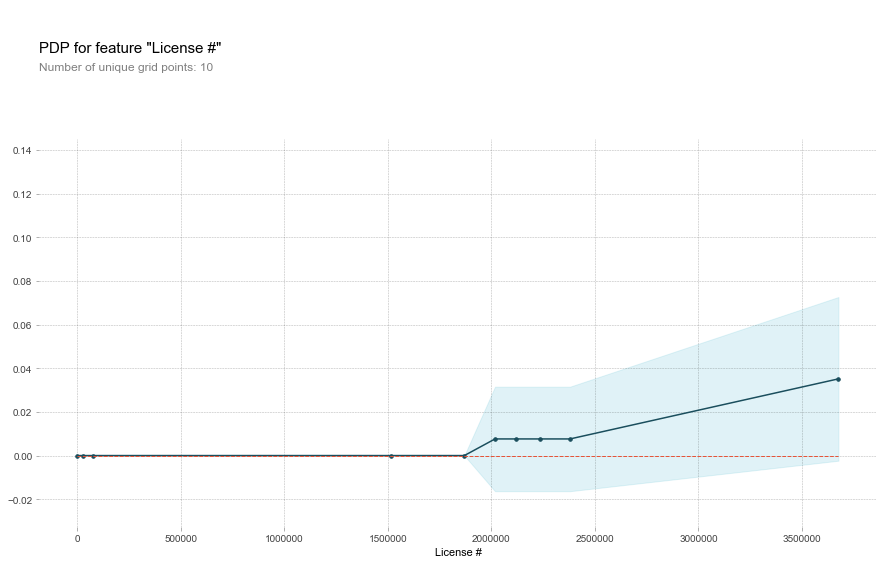

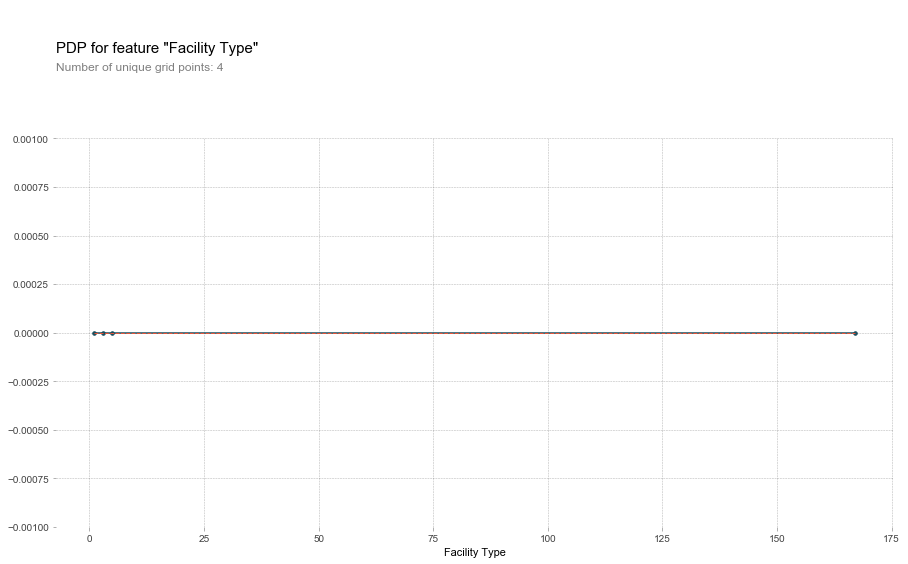

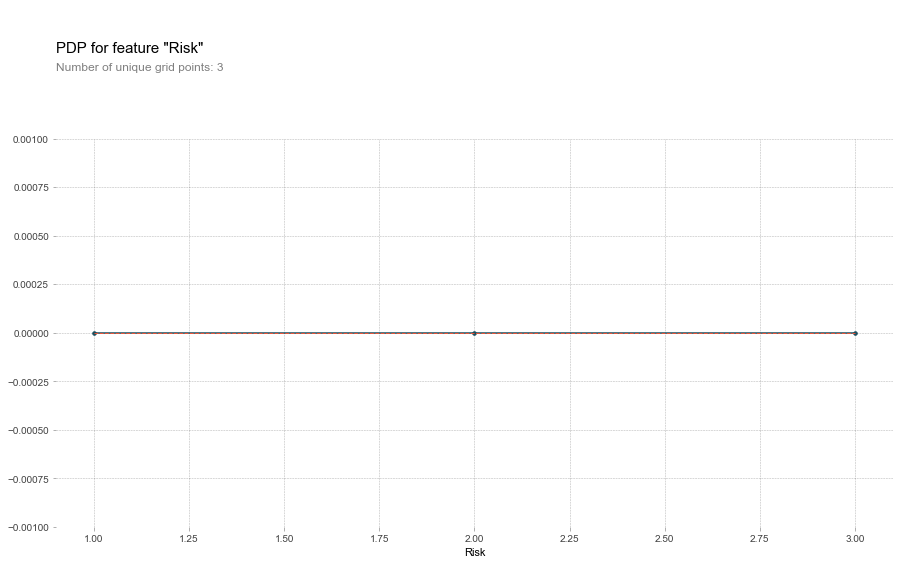

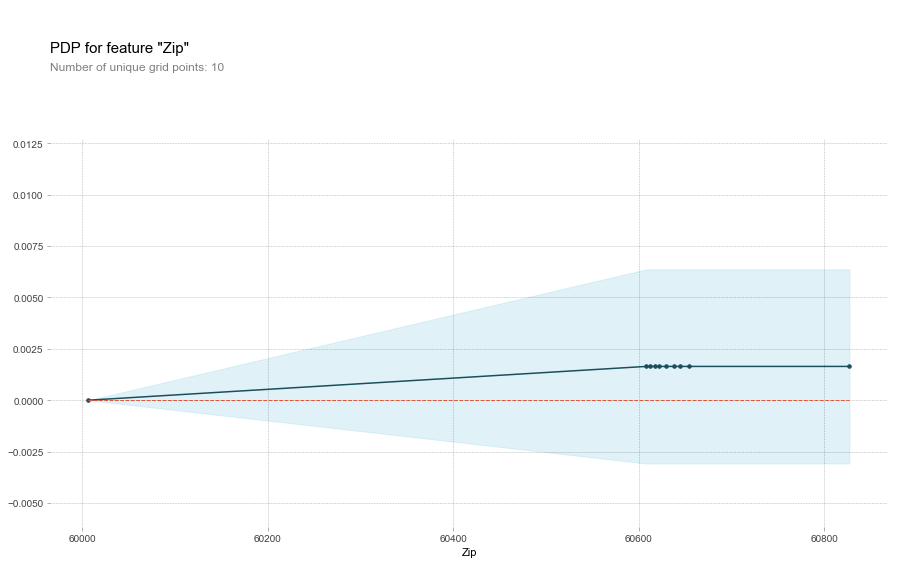

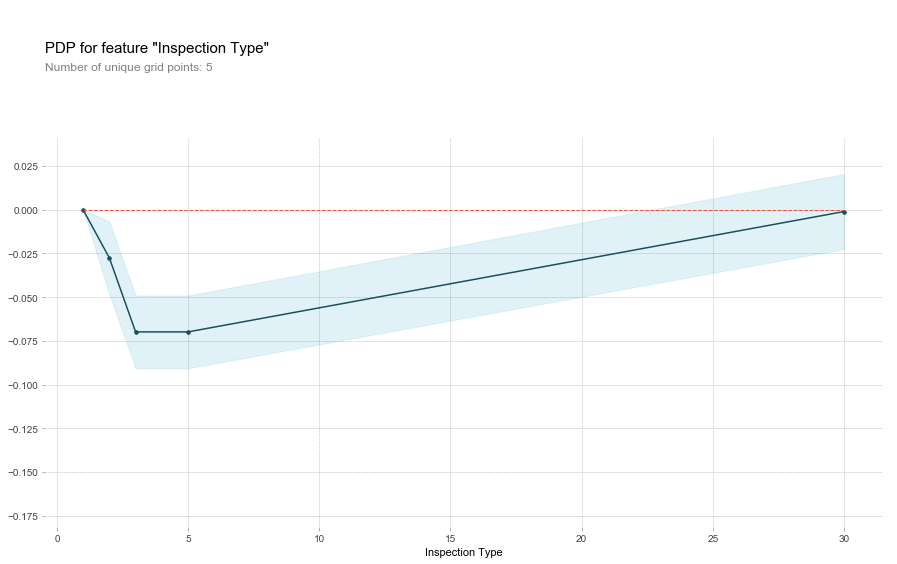

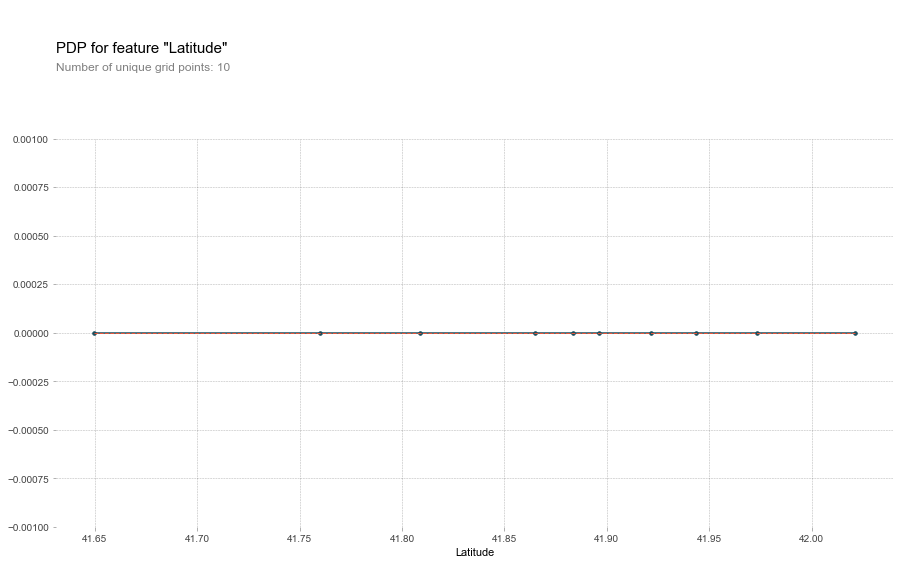

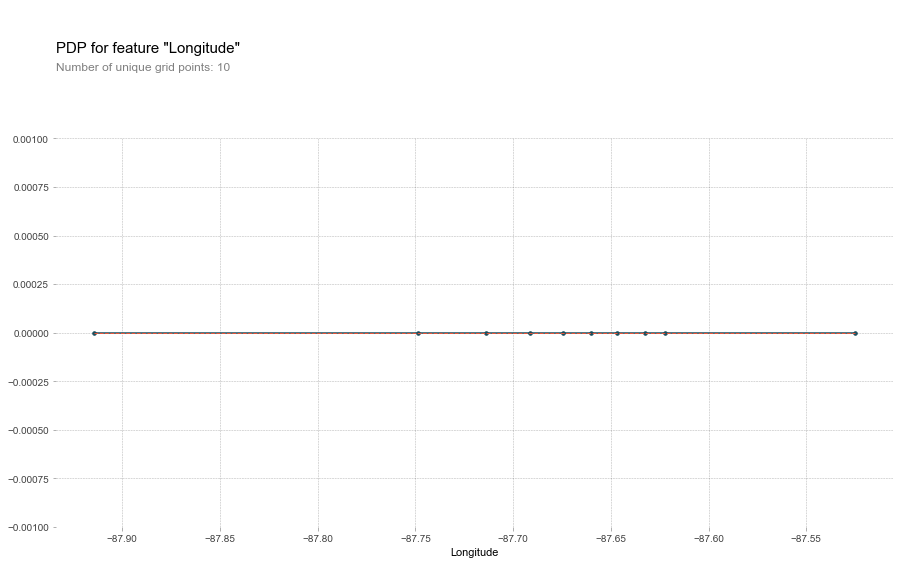

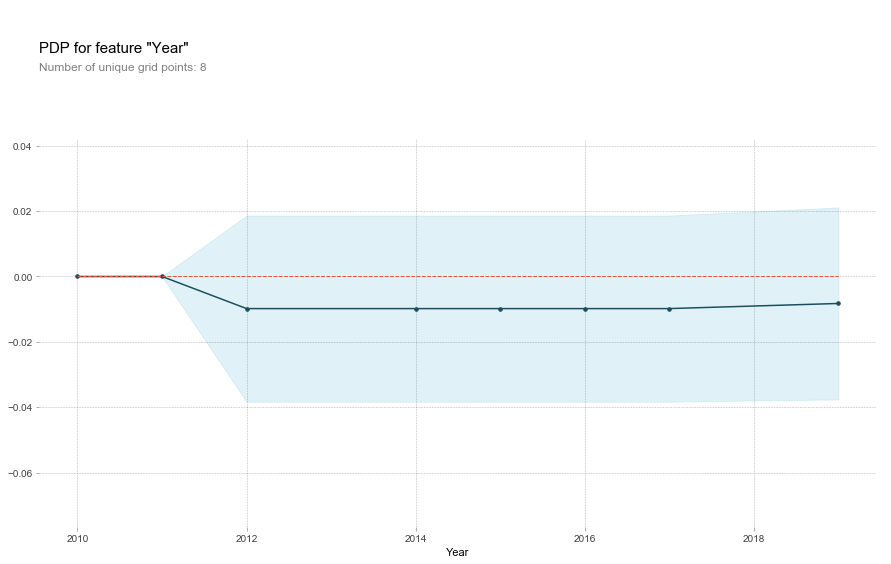

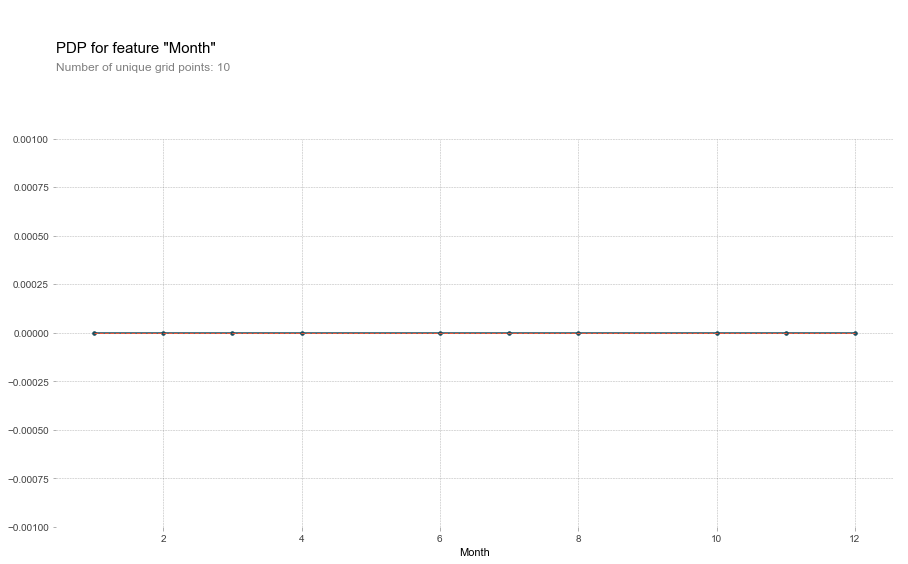

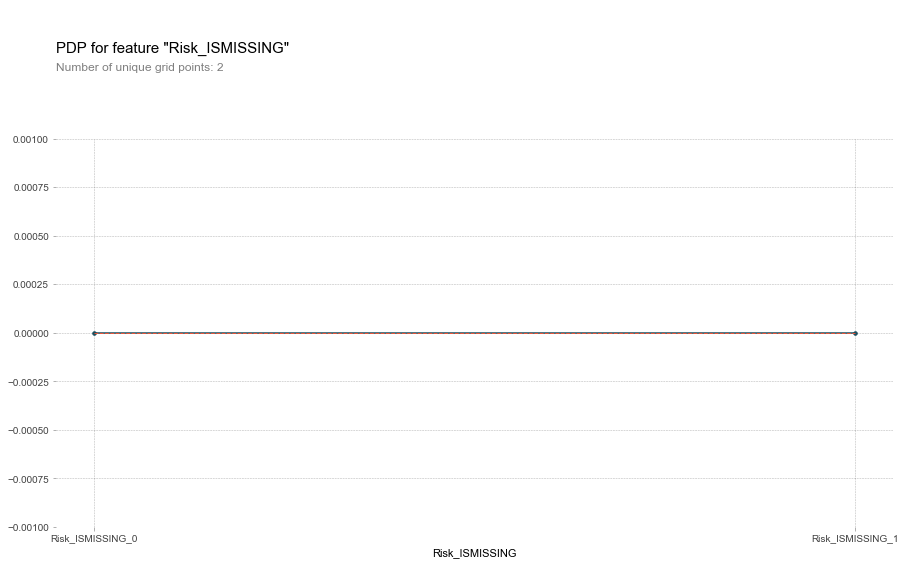

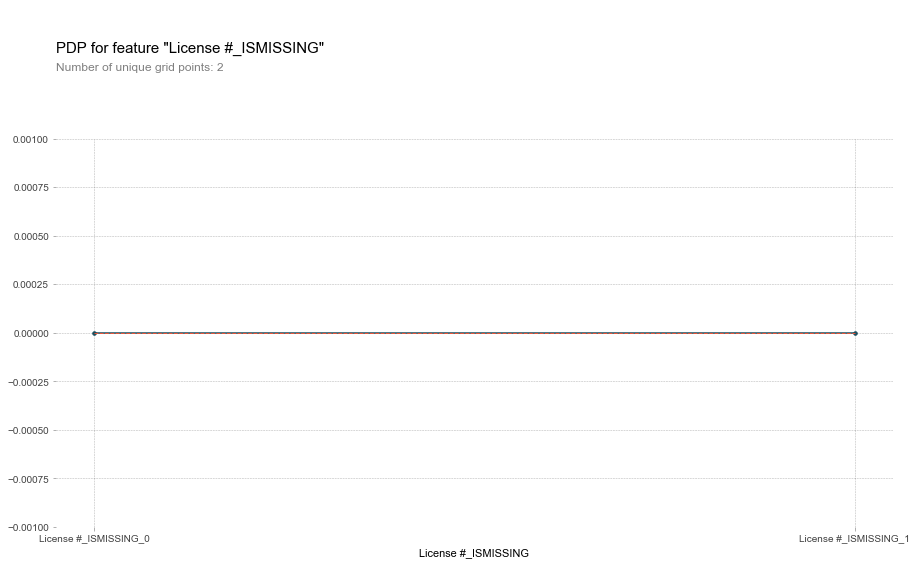

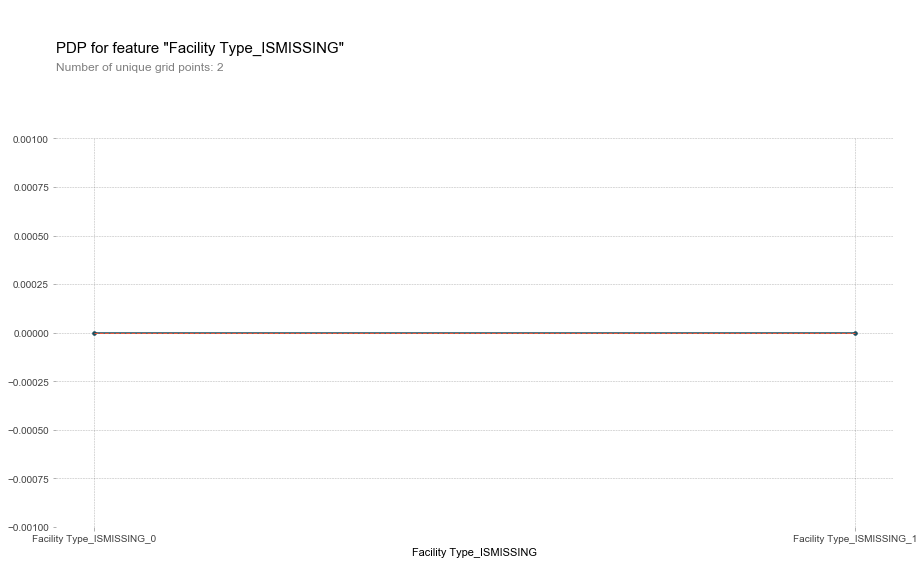

In [551]:
features = list(x_val_p.columns)
for feature in features:
    isolated = pdp_isolate(
        model=model_one, 
        dataset=x_val_p, 
        model_features=x_val_p.columns, 
        feature=feature
    )

    pdp_plot(isolated, feature_name=feature)

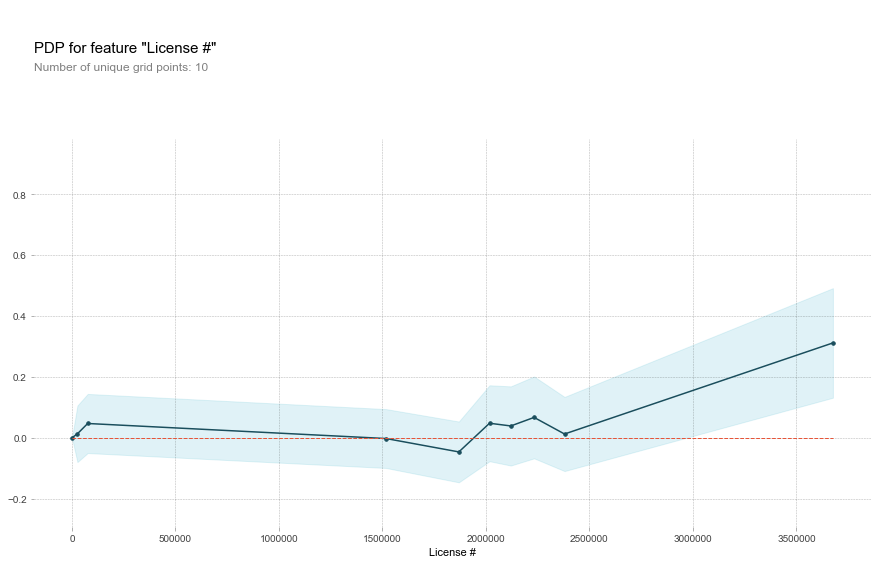

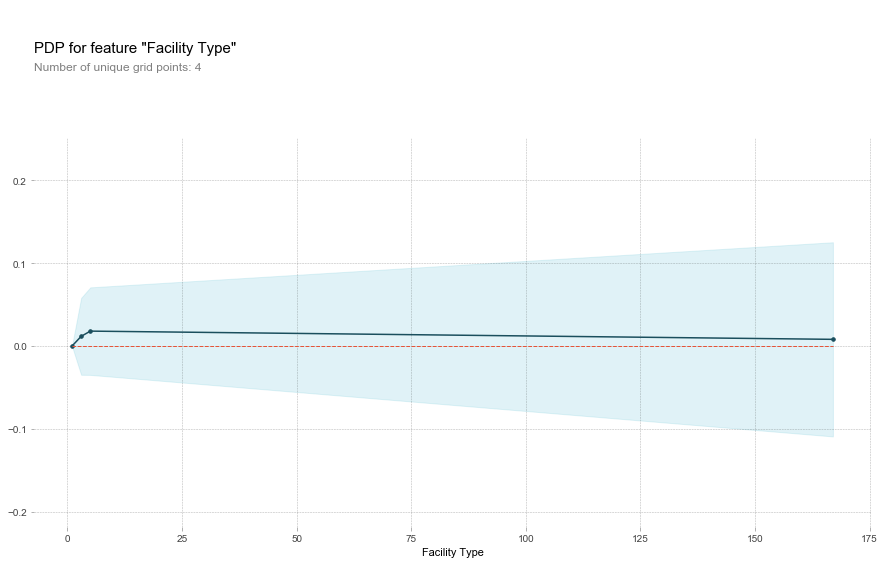

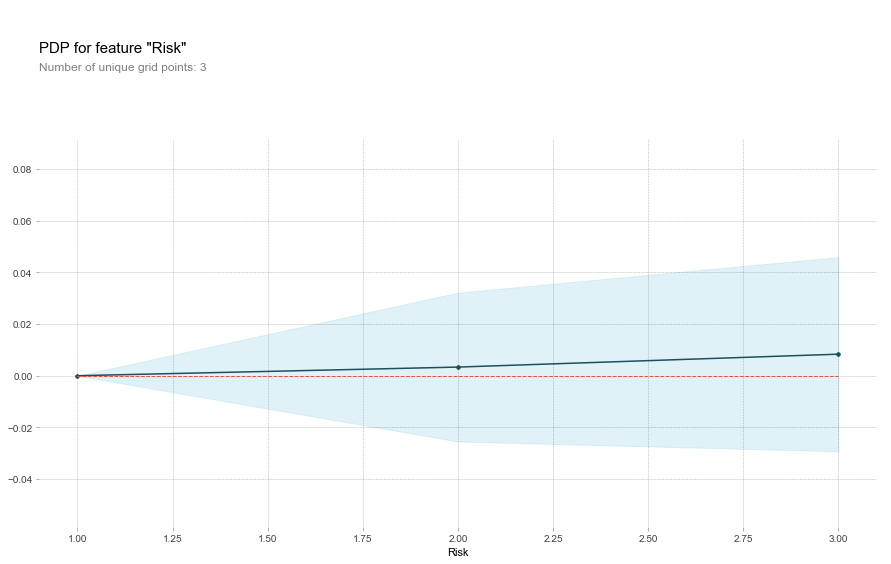

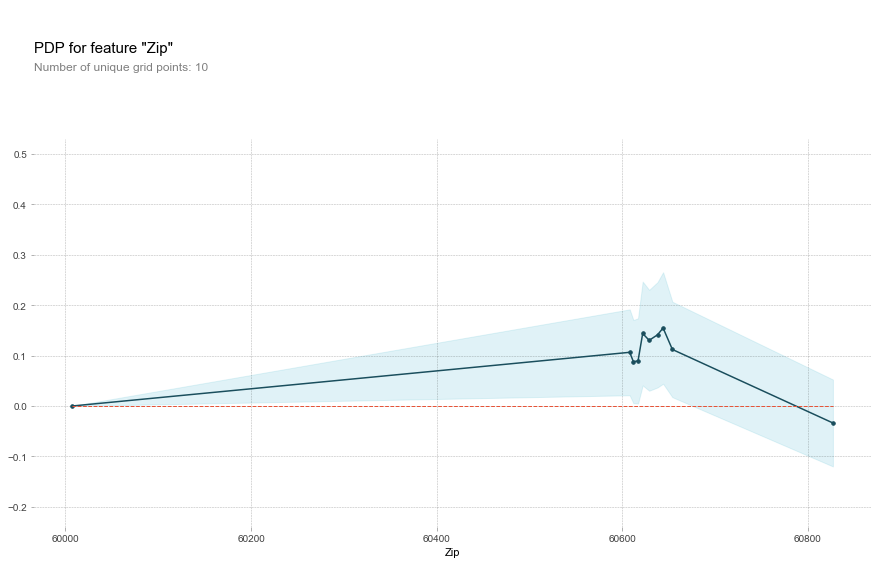

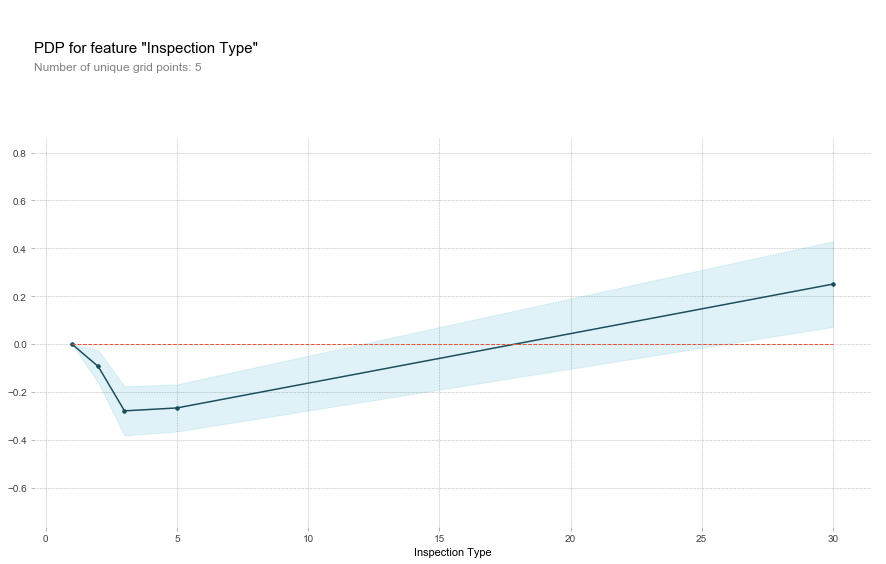

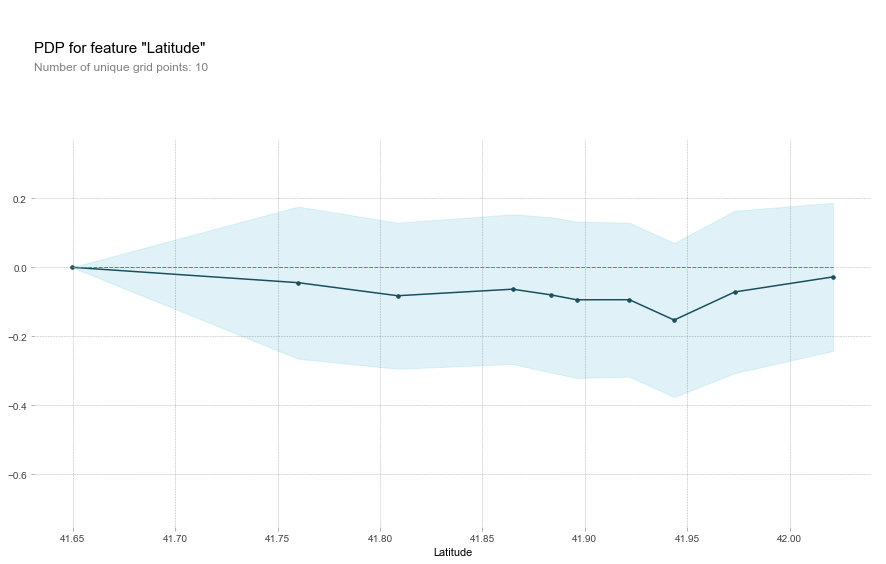

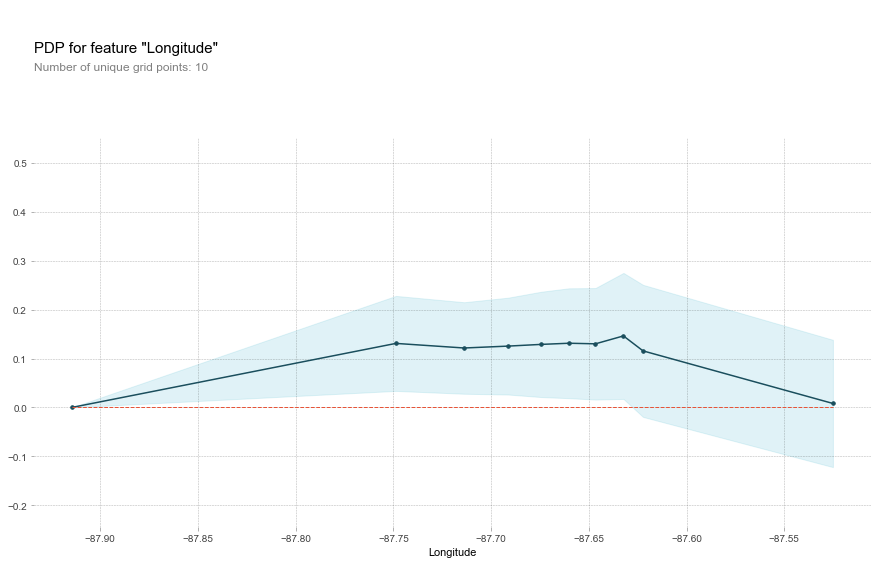

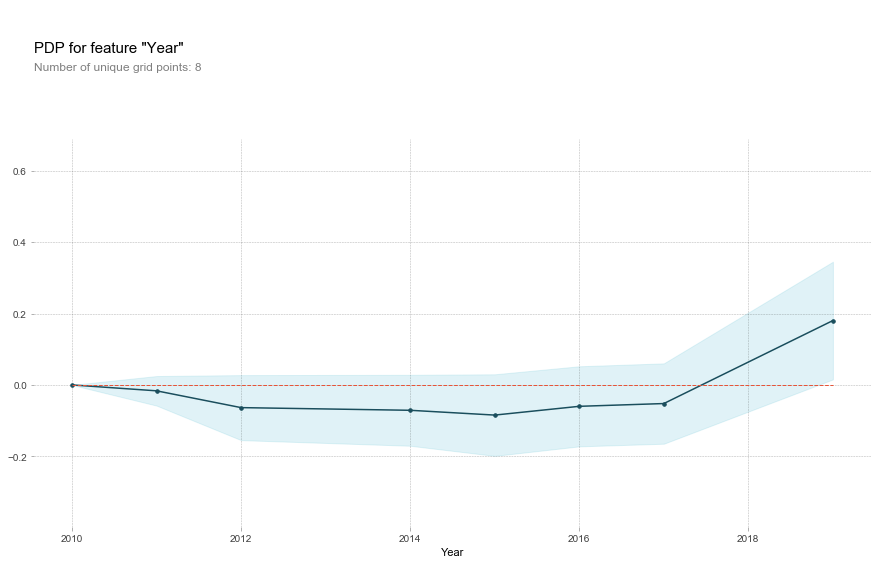

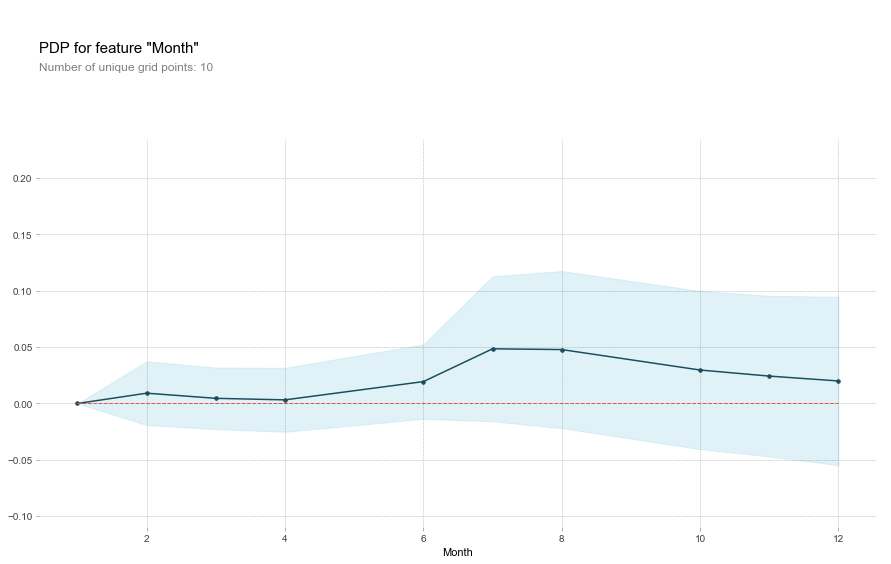

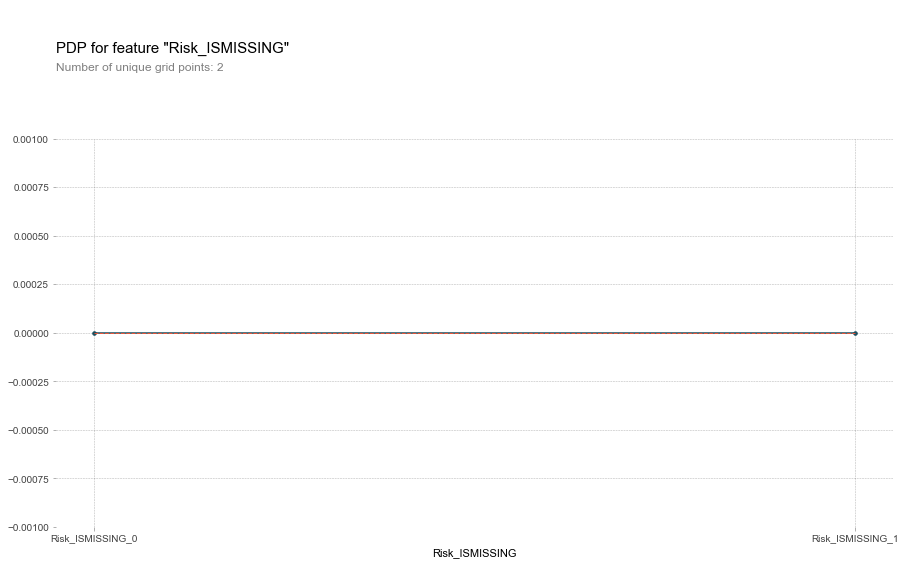

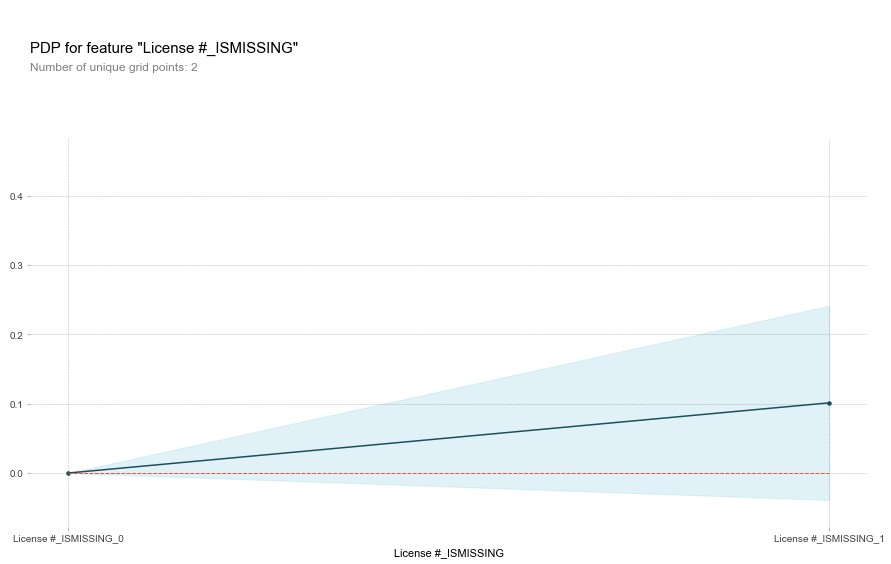

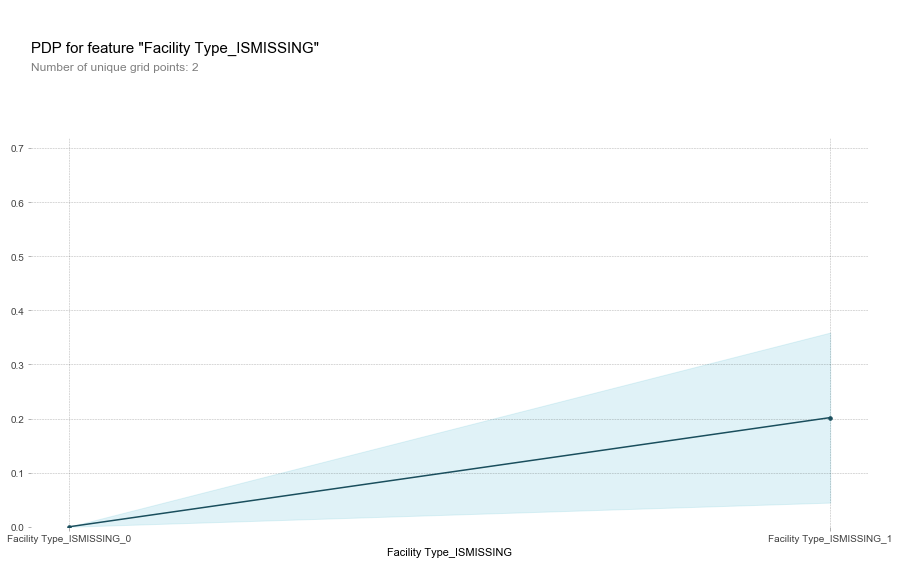

In [552]:
features = list(x_val_p.columns)
for feature in features:
    isolated = pdp_isolate(
        model=model_two, 
        dataset=x_val_p, 
        model_features=x_val_p.columns, 
        feature=feature
    )

    pdp_plot(isolated, feature_name=feature)

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?

ANSWER:

#### Gradient Descent seeks to minimize model error
- What is the "Learning Rate" and what is its function?

ANSWER:

#### Learning Rate is the 'step' a gradient descent model takes to check the slope. A model will check the slope at its current location, then move a Learning Rate amount in the direction of negative descent, then the model will check the slope at its current location. And repeat.
One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._